In [2]:
# This cell is from the template notebook. It contains ipython magic and 
# various useful imports which are commonly used in this app.

%load_ext autoreload
%autoreload 2

import pandas as pd
import datetime
import numpy as np
import os
from acoustic_data_science import config, helpers, analysis
#import acoustic_data_science.analysis.transient_durations as transient_durations
import acoustic_data_science
import matplotlib.pyplot as plt
import logging

- Data is loudness against time with loudness in each TOL.
- Want to see transients labelled as such.
- Want to know the duration of each transient.
- Want to retain its frequency information, perhaps even the full spectrogram.

Ideal final data structure:
- Dataframe which contains the timestamp at which each transient starts and its duration.
- Can use this timestamp & duration to further investigate the transient e.g. lookup its spectrogram.

#   Get transient durations with timestamps

In [360]:
df = pd.read_feather(helpers.feather_path_from_month_name(config.processed_data_path, '2018_09'), columns=['timestamp', 'loud'])

df = df[df["loud"]]
df

,timestamp,loud
123,2018-09-01 00:11:03.000,True
421,2018-09-01 00:13:32.000,True
429,2018-09-01 00:13:36.000,True
430,2018-09-01 00:13:36.500,True
433,2018-09-01 00:13:38.000,True
...,...,...
3634595,2018-09-30 21:45:59.000,True
3634596,2018-09-30 21:45:59.500,True
3634608,2018-09-30 21:46:05.500,True
3634609,2018-09-30 21:46:06.000,True


In [361]:
df["increasing_count"] = np.arange(df.shape[0])
df["transient_group"] = df.index - df["increasing_count"]
df["duration"] = np.full(len(df), 0.5)
df

,timestamp,loud,increasing_count,transient_group,duration
123,2018-09-01 00:11:03.000,True,0,123,0.5
421,2018-09-01 00:13:32.000,True,1,420,0.5
429,2018-09-01 00:13:36.000,True,2,427,0.5
430,2018-09-01 00:13:36.500,True,3,427,0.5
433,2018-09-01 00:13:38.000,True,4,429,0.5
...,...,...,...,...,...
3634595,2018-09-30 21:45:59.000,True,54477,3580118,0.5
3634596,2018-09-30 21:45:59.500,True,54478,3580118,0.5
3634608,2018-09-30 21:46:05.500,True,54479,3580129,0.5
3634609,2018-09-30 21:46:06.000,True,54480,3580129,0.5


In [362]:
transient_durations_series = df.groupby(['transient_group'])['duration'].sum()
# Starting index of transients gets lost when grouping.
# Recover by taking cumulative sum of the durations and divide by the duration length (0.5 s) to get the number of skipped rows.
transient_durations_df_index = (transient_durations_series.index + transient_durations_series.cumsum(axis=0)/0.5 - np.ones(len(transient_durations_series))).astype('int').values

transient_durations_df = pd.DataFrame({'transient_group':transient_durations_df_index, 'duration':transient_durations_series.values})
transient_durations_df

,transient_group,duration
0,123,0.5
1,421,0.5
2,430,1.0
3,462,15.0
4,465,1.0
...,...,...
5250,3634590,1.0
5251,3634593,1.0
5252,3634596,1.0
5253,3634609,1.0


In [363]:
transient_durations_df["timestamp"] = df[df.index.isin(transient_durations_df["transient_group"])]['timestamp'].values
df[df.index.isin(transient_durations_df["transient_group"])]['timestamp']
transient_durations_df.head(50)

,transient_group,duration,timestamp
0,123,0.5,2018-09-01 00:11:03.000
1,421,0.5,2018-09-01 00:13:32.000
2,430,1.0,2018-09-01 00:13:36.500
3,462,15.0,2018-09-01 00:13:52.500
4,465,1.0,2018-09-01 00:13:54.000
5,711,0.5,2018-09-01 00:15:57.000
6,990,0.5,2018-09-01 00:18:17.000
7,1373,0.5,2018-09-01 00:21:29.000
8,1496,4.5,2018-09-01 00:22:30.500
9,1652,0.5,2018-09-01 00:23:48.500


#   Extend to whole year

In [4]:
def get_transients(df, average_tols=False):
    # Just get the loud events.
    df = df[df["loud"]]

    # Each transient has a number called transient_group.
    # Half-seconds in the same transient have the same transient_group.
    df.loc[:, "transient_group"] = df.index - np.arange(df.shape[0])
    # Recover the original index lost by grouping.
    # =========================================================================
    df.loc[:, "duration"] = np.full(len(df), 0.5).tolist()
    transient_groups_summed = df.groupby(['transient_group']).sum()
    durations = transient_groups_summed["duration"]

    # Starting index of transients gets lost when grouping.
    # Recover by taking cumulative sum of the durations and divide by the duration length (0.5 s) to get the number of skipped rows.
    durations_index = (durations.index + durations.cumsum(axis=0)/0.5 - np.ones(len(durations))).astype('int').values
    # =========================================================================

    transients_df = df[df.index.isin(durations_index)]
    transients_df.loc[:, "duration"] = durations.values
    transients_df.drop(columns=['transient_group'], inplace=True)

    transients_df = transients_df.reset_index(drop=True)

    if average_tols:
        transients_df.loc[:, "25":"25119"] = transients_df.loc[:, "25":"25119"]#.div(transients_df["duration"]/0.5, axis=0)
    
    return transients_df

In [366]:
monthly_feather_paths = helpers.get_feather_paths(config.processed_data_path + '/monthly_data')
month_names = helpers.get_month_names(config.processed_data_path + '/monthly_data')
for monthly_feather_path, month_name in zip(monthly_feather_paths, month_names):
    df = pd.read_feather(monthly_feather_path).drop(columns=['unnormalised_broadband_spl', "short_transient"])
    transients_df = get_transients(df, average_tols=True)
    #transients_df.to_feather(os.path.join(config.processed_data_path,f'transients/{month_name}.feather'))


/Users/georgeamccarthy/opt/anaconda3/envs/ads/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/georgeamccarthy/opt/anaconda3/envs/ads/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/georgeamccarthy/opt/anaconda3/envs/ads/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is tryi

In [5]:
whole_year_df = pd.read_feather(config.processed_data_path + '/whole_year/whole_year.feather')
whole_year_df["loud"] = whole_year_df["broadband_spl"] > whole_year_df["background_spl"] + 10
whole_year_transients_df = get_transients(whole_year_df)
whole_year_transients_df = whole_year_transients_df.drop(columns=["loud"])
#whole_year_transients_df.to_feather(config.processed_data_path + '/transient_timestamps_and_durations/whole_year.feather')
whole_year_transients_df

/Users/georgeamccarthy/opt/anaconda3/envs/ads/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/georgeamccarthy/opt/anaconda3/envs/ads/lib/python3.8/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/georgeamccarthy/opt/anaconda3/envs/ads/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is tryi

,timestamp,broadband_spl,background_spl,duration
0,2018-08-02 00:23:09.500,-48.511243,-59.933503,0.5
1,2018-08-02 00:23:10.500,-44.798160,-59.914447,0.5
2,2018-08-02 00:23:11.500,-49.693166,-59.900054,0.5
3,2018-08-02 00:23:13.000,-48.039116,-59.874419,1.0
4,2018-08-02 00:25:16.500,-44.149546,-54.485586,121.5
...,...,...,...,...
412305,2019-05-31 22:51:03.855,-43.255208,-64.609792,0.5
412306,2019-05-31 22:53:22.507,-52.194121,-64.656006,0.5
412307,2019-05-31 22:56:58.507,-52.946478,-64.694019,2.0
412308,2019-05-31 22:57:27.507,-48.559140,-63.667097,28.5


In [6]:
whole_year_transients_df = pd.read_feather(config.processed_data_path + '/transient_timestamps_and_durations/whole_year.feather')

#   Compare to old code which gets durations without any other info.

In [14]:
df = pd.read_feather(config.processed_data_path + "/whole_year/whole_year.feather")
df["loud"] = df["broadband_spl"] > df["background_spl"] + 20
print(len(df))

# Old func.
def get_transient_durations(df):
    df = df[df["loud"]]

    # Mask df to only get loud rows.
    df['transient_group'] = (df.index - np.arange(df.shape[0]))
    index_groups = df['transient_group'].unique()
    
    transient_durations = []
    for index_group in index_groups:
        transient_times = df[df['transient_group']==index_group]['timestamp'].values
        transient_durations.append((transient_times[-1] - transient_times[0]).astype('float')/1e9 + 0.5)
    
    # Cull any detected transient with length longer than 5 mins. Arbitrary for now.
    #transient_durations[i] = transient_durations[transient_durations < 5*60]
    transient_durations = np.array(transient_durations)
    return transient_durations

transient_durations = get_transient_durations(df)
transient_durations.max()

30048625


/var/folders/xw/j5fzsq4j5d5gfqy4tsdkbz0h0000gn/T/ipykernel_55937/2746565188.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transient_group'] = (df.index - np.arange(df.shape[0]))


3118.5

#   Plot all durations on one plot with colour coding.

In [8]:
def get_transient_duration_occurances_per_day(df):
    # Floor timestamp column to the day to get YYYY-MM-DD
    df["day"] = df['timestamp'].dt.floor('D')
    # For each day, contain the durations of transients found and the number
    # of times transients of that length occur in the data.
    transient_duration_occurances_per_day = df.groupby(["day", "duration"]).size()

    return transient_duration_occurances_per_day

#print(whole_year_transients_df["duration"].max())

transient_duration_occurances_per_day = get_transient_duration_occurances_per_day(whole_year_transients_df)
transient_duration_occurances_per_day

day         duration
2018-08-02  0.5         347
            1.0          88
            1.5          50
            2.0          22
            2.5          11
                       ... 
2019-05-31  40.5          1
            46.0          2
            47.0          1
            56.0          1
            63.5          1
Length: 10898, dtype: int64

In [10]:
short_transients_df = whole_year_transients_df[whole_year_transients_df["duration"] <= 0.5].groupby("day").size()
med_short_transients_df = whole_year_transients_df[(0.5 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 5)].groupby("day").size()
med_transients_df = whole_year_transients_df[(5 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 3*60)].groupby("day").size()
long_transients_df = whole_year_transients_df[(3*60 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 20*60)].groupby("day").size()
all_transients_df = whole_year_transients_df.groupby("day").size()
all_transients_df

day
2018-08-02     603
2018-08-04     273
2018-08-05     398
2018-08-06    1112
2018-08-07     766
              ... 
2019-05-27    2259
2019-05-28    1859
2019-05-29     271
2019-05-30    2704
2019-05-31    2604
Length: 287, dtype: int64

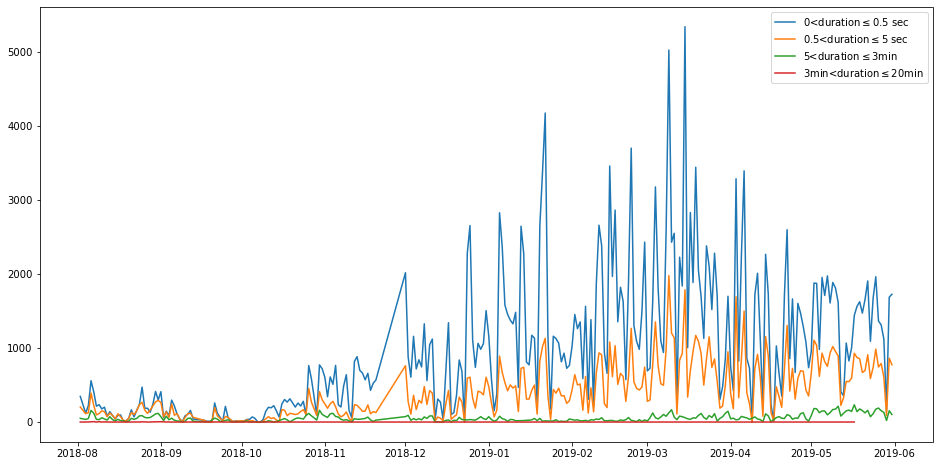

In [18]:
short_transients_df = whole_year_transients_df[whole_year_transients_df["duration"] <= 0.5].groupby("day").size()
med_short_transients_df = whole_year_transients_df[(0.5 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 5)].groupby("day").size()
med_transients_df = whole_year_transients_df[(5 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 3*60)].groupby("day").size()
long_transients_df = whole_year_transients_df[(3*60 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 20*60)].groupby("day").size()

plt.figure(figsize=(16,8))

x = short_transients_df.index
y = short_transients_df.values
plt.plot(x, y, label=r"$0 \less \rm{duration} \leq 0.5$ sec")

x = med_short_transients_df.index
y = med_short_transients_df.values
plt.plot(x, y, label=r"$0.5 \less \rm{duration} \leq 5$ sec")

x = med_transients_df.index
y = med_transients_df.values
plt.plot(x, y, label=r"$5 \less \rm{duration} \leq 3 \rm{min}$")

x = long_transients_df.index
y = long_transients_df.values
plt.plot(x, y, label=r"$3 \rm{min} \less \rm{duration} \leq 20 \rm{min}$")

plt.legend()
plt.show()

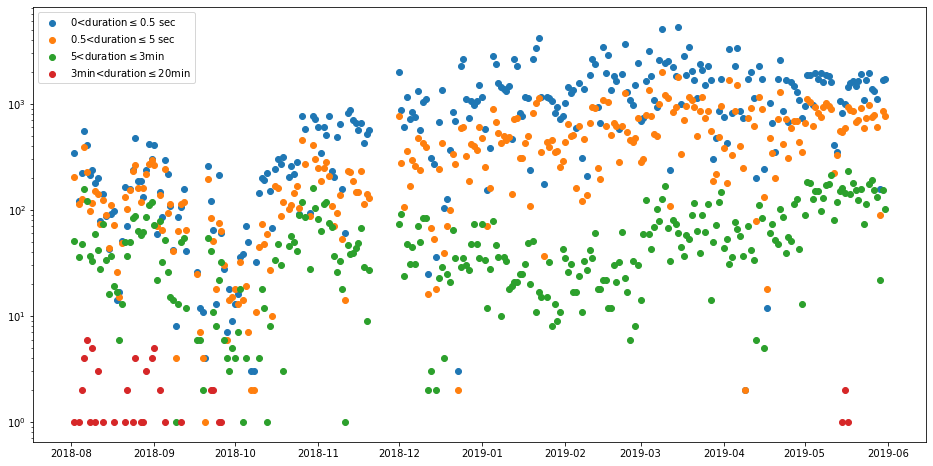

In [15]:
short_transients_df = whole_year_transients_df[whole_year_transients_df["duration"] <= 0.5].groupby("day").size()
med_short_transients_df = whole_year_transients_df[(0.5 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 5)].groupby("day").size()
med_transients_df = whole_year_transients_df[(5 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 3*60)].groupby("day").size()
long_transients_df = whole_year_transients_df[(3*60 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 20*60)].groupby("day").size()

plt.figure(figsize=(16,8))

x = short_transients_df.index
y = short_transients_df.values
plt.scatter(x, y, label=r"$0 \less \rm{duration} \leq 0.5$ sec")

x = med_short_transients_df.index
y = med_short_transients_df.values
plt.scatter(x, y, label=r"$0.5 \less \rm{duration} \leq 5$ sec")

x = med_transients_df.index
y = med_transients_df.values
plt.scatter(x, y, label=r"$5 \less \rm{duration} \leq 3 \rm{min}$")

x = long_transients_df.index
y = long_transients_df.values
plt.scatter(x, y, label=r"$3 \rm{min} \less \rm{duration} \leq 20 \rm{min}$")

plt.legend()
plt.show()


2021-12-10 12:57:11,302 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-12-10 12:57:11,303 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-12-10 12:57:11,309 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-12-10 12:57:11,313 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-12-10 12:57:11,

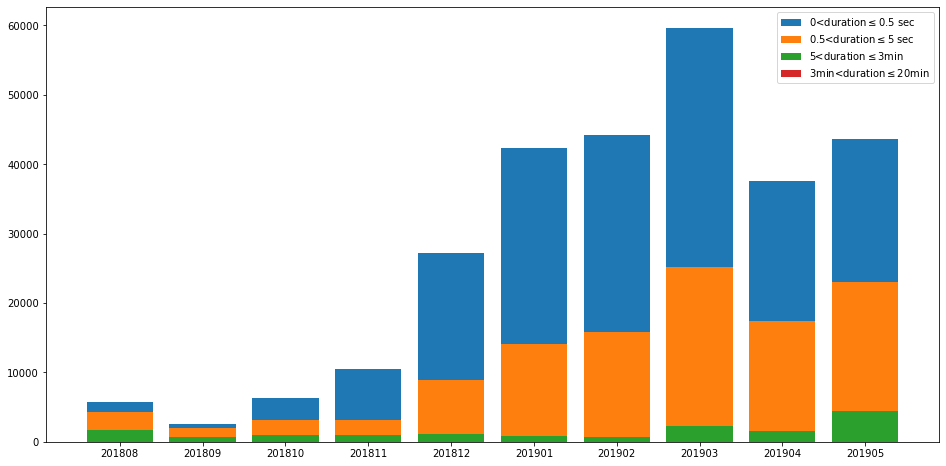

In [20]:
whole_year_transients_df["month"] = whole_year_transients_df['timestamp'].apply(lambda x: '{year}{month:02}'.format(year=x.year, month=x.month)).values

short_transients_df = whole_year_transients_df[whole_year_transients_df["duration"] <= 0.5].groupby("month").size()
med_short_transients_df = whole_year_transients_df[(0.5 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 5)].groupby("month").size()
med_transients_df = whole_year_transients_df[(5 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 3*60)].groupby("month").size()
long_transients_df = whole_year_transients_df[(3*60 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 20*60)].groupby("month").size()

plt.figure(figsize=(16,8))

x = short_transients_df.index
y = short_transients_df.values
plt.bar(x, y, label=r"$0 \less \rm{duration} \leq 0.5$ sec")

x = med_short_transients_df.index
y = med_short_transients_df.values
plt.bar(x, y, label=r"$0.5 \less \rm{duration} \leq 5$ sec")

x = med_transients_df.index
y = med_transients_df.values
plt.bar(x, y, label=r"$5 \less \rm{duration} \leq 3 \rm{min}$")

x = long_transients_df.index
y = long_transients_df.values
plt.bar(x, y, label=r"$3 \rm{min} \less \rm{duration} \leq 20 \rm{min}$")

plt.legend()
plt.show()

In [21]:
whole_year_transients_df[whole_year_transients_df["duration"]>5*60]

,timestamp,broadband_spl,background_spl,duration,day,month
1654,2018-08-06 07:42:54.500,-42.003788,-56.401869,312.5,2018-08-06,201808
2033,2018-08-06 16:15:55.500,-41.520484,-51.520948,389.0,2018-08-06,201808
3872,2018-08-09 15:51:30.500,-43.141583,-53.445794,316.5,2018-08-09,201808
4416,2018-08-11 16:17:16.500,-43.005158,-53.058475,348.5,2018-08-11,201808
11143,2018-08-31 07:01:19.000,-46.982676,-57.002315,323.0,2018-08-31,201808
11177,2018-08-31 12:52:09.500,-50.239350,-60.577106,319.0,2018-08-31,201808
13129,2018-09-05 00:50:50.500,-32.947084,-43.800093,452.5,2018-09-05,201809
16128,2018-09-23 10:26:22.000,-5.688670,-15.946035,331.0,2018-09-23,201809
376990,2019-05-16 14:58:22.007,-22.005385,-38.375865,303.5,2019-05-16,201905
377037,2019-05-16 16:43:57.007,-21.406829,-31.787782,420.0,2019-05-16,201905


In [121]:
ice_concentration = pd.read_csv(config.processed_data_path + '/cambridge_bay_sea_ice_properties_from_ice_charts.csv')[["timestamp", "total_concentration", "mean_temperature"]]
ice_concentration = ice_concentration.replace(np.nan, 0)

ice_concentration["timestamp"] = ice_concentration["timestamp"].apply(pd.to_datetime)
ice_concentration["month"] = ice_concentration['timestamp'].apply(lambda x: '{year}{month:02}'.format(year=x.year, month=x.month)).values
#ice_concentration_monthly = ice_concentration.groupby("month").mean()
#ice_concentration_monthly = ice_concentration_monthly.sort_values(["month"])

#ice_concentration_monthly[201808 <= ice_concentration_monthly["month"]]
ice_concentration_monthly = ice_concentration.drop(columns=["timestamp"]).groupby("month", as_index=False).mean()
ice_concentration_monthly["total_concentration"] = ice_concentration_monthly["total_concentration"].round()
#ice_concentration_monthly[201808 < int(ice_concentration_monthly["month"])]

new_row = {'month':'201808', 'total_concentration':0}
ice_concentration_monthly = ice_concentration_monthly.append(new_row, ignore_index=True)
ice_concentration_monthly = ice_concentration_monthly.sort_values(["month"]).reset_index(drop=True)

ice_concentration_monthly = ice_concentration_monthly[ice_concentration_monthly["month"].astype("int") <= 201905]
ice_concentration_monthly.to_csv(config.processed_data_path + '/monthly_ice_concentration.csv', index=False)
ice_concentration_monthly


,month,total_concentration,mean_temperature
0,201808,0.0,NaN
1,201809,0.0,-0.250
2,201810,5.0,-9.100
3,201811,10.0,-23.175
4,201812,10.0,-24.520
5,201901,10.0,-31.700
6,201902,10.0,-32.725
7,201903,10.0,-23.625
8,201904,10.0,-22.640
9,201905,10.0,-9.625


2021-12-18 20:35:11,455 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-12-18 20:35:11,457 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-12-18 20:35:11,462 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


NameError: name 'ice_concentration_monthly' is not defined

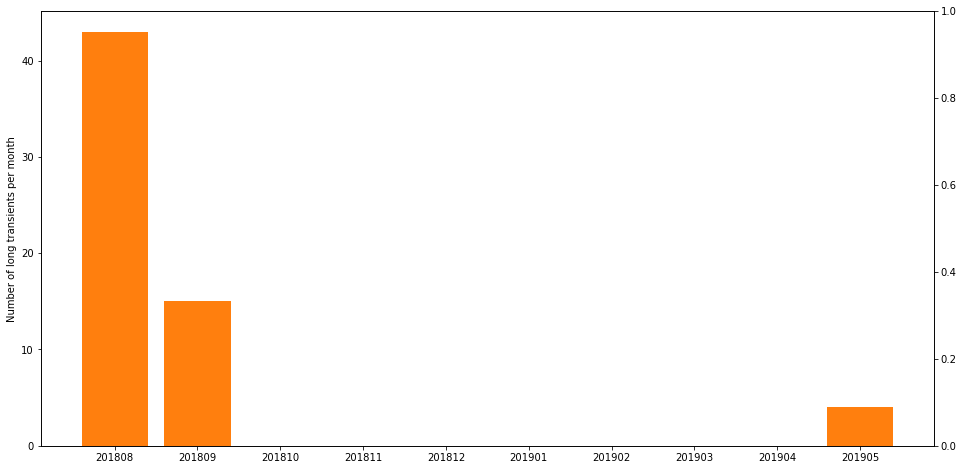

In [170]:
whole_year_transients_df["month"] = whole_year_transients_df['timestamp'].apply(lambda x: '{year}{month:02}'.format(year=x.year, month=x.month)).values

short_transients_df = whole_year_transients_df[whole_year_transients_df["duration"] <= 0.5].groupby("month").size()
med_short_transients_df = whole_year_transients_df[(0.5 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 5)].groupby("month").size()
med_transients_df = whole_year_transients_df[(5 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 3*60)].groupby("month").size()
long_transients_df = whole_year_transients_df[(3*60 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 20*60)].groupby("month").size()

fig, ax = plt.subplots(1,1,figsize=(16,8))

ax.bar(whole_year_transients_df["month"].unique(), 0)

x = long_transients_df.index
y = long_transients_df.values
ax.bar(x, y, label=r"$3 \rm{min} \less \rm{duration} \leq 20 \rm{min}$")
ax.set_ylabel("Number of long transients per month")

ax2 = ax.twinx()
ax.set_ylabel("Number of long transients per month")
x = ice_concentration_monthly["month"]
y = ice_concentration_monthly["total_concentration"]
ax2.set_ylabel("Ice concentration (/10)")
ax2.scatter(x, y, label="Ice concentration")
ax2.plot(x, y)

ax.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

In [16]:
ice_data = pd.read_csv(config.external_data_path + '/hazel_ice_data.csv')
ice_data['timestamp'] = pd.to_datetime(ice_data['Date'], dayfirst=True)  #change to datetime format 
ice_data['Concentration'].replace({'no ice':0}, inplace=True)   #replace with numerical formatting
ice_data['Concentration'] = pd.to_numeric(ice_data['Concentration'])  
ice_data = ice_data[(ice_data["timestamp"].dt.month < 6) | (ice_data["timestamp"].dt.year == 2018)] 
ice_data = ice_data.groupby(pd.Grouper(key="timestamp", freq='1M')).mean().reset_index()
ice_data['timestamp'] = ice_data['timestamp'].dt.strftime('%Y-%m')

ice_data

,timestamp,Concentration,Mean Temperature,Normal Temperature,Ice Profiler
0,2018-08,0.000,NaN,NaN,0.000000
1,2018-09,0.000,-0.250,0.800,-0.036249
2,2018-10,0.500,-9.100,-8.550,0.058218
3,2018-11,0.975,-23.175,-21.625,0.452721
4,2018-12,1.000,-24.520,-29.060,0.719427
5,2019-01,1.000,-31.700,-30.925,1.039574
6,2019-02,1.000,-32.725,-33.100,1.308955
7,2019-03,1.000,-23.625,-30.875,1.500855
8,2019-04,1.000,-22.640,-22.360,1.671275
9,2019-05,1.000,-9.625,-8.800,1.787357


In [12]:
retained_data_df = pd.read_csv(config.external_data_path + '/retained_data.csv')
retained_data_df["timestamp"] = pd.to_datetime(retained_data_df["month"], format="%Y/%m")
retained_data_df['timestamp'] = retained_data_df['timestamp'].dt.strftime('%Y-%m')

retained_data_df["retained"] = retained_data_df["retained"]/100
retained_data_df = retained_data_df.drop(columns=['month'])
retained_data_df

,retained,timestamp
0,0.9895,2018-08
1,0.9296,2018-09
2,0.8319,2018-10
3,0.3729,2018-11
4,0.7310,2018-12
5,0.7202,2019-01
6,0.6594,2019-02
7,0.7536,2019-03
8,0.5314,2019-04
9,0.6687,2019-05


In [25]:
freq = '1M'

short_transients_df = whole_year_transients_df[whole_year_transients_df["duration"] <= 0.5].groupby(pd.Grouper(key="timestamp", freq=freq), as_index=False).size()
med_short_transients_df = whole_year_transients_df[(0.5 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 5)].groupby(pd.Grouper(key="timestamp", freq=freq), as_index=False).size()
med_transients_df = whole_year_transients_df[(5 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 3*60)].groupby(pd.Grouper(key="timestamp", freq=freq), as_index=False).size()
long_transients_df = whole_year_transients_df[(3*60 < whole_year_transients_df["duration"]) & (whole_year_transients_df["duration"] <= 20*60)].groupby(pd.Grouper(key="timestamp", freq=freq), as_index=False).size()
all_transients_df = whole_year_transients_df.groupby(pd.Grouper(key="timestamp", freq=freq), as_index=False).size()

#========= Correct for cleaned data (nans removed)
short_transients_df['Date'] = short_transients_df['timestamp'].dt.strftime('%m-%Y')
med_short_transients_df['Date'] = med_short_transients_df['timestamp'].dt.strftime('%m-%Y')
med_transients_df['Date'] = med_transients_df['timestamp'].dt.strftime('%m-%Y')
long_transients_df['Date'] = long_transients_df['timestamp'].dt.strftime('%m-%Y')
all_transients_df['Date'] = all_transients_df['timestamp'].dt.strftime('%m-%Y')

short_transients_df['timestamp'] = short_transients_df['timestamp'].dt.strftime('%Y-%m')
med_short_transients_df['timestamp'] = med_short_transients_df['timestamp'].dt.strftime('%Y-%m')
med_transients_df['timestamp'] = med_transients_df['timestamp'].dt.strftime('%Y-%m')
long_transients_df['timestamp'] = long_transients_df['timestamp'].dt.strftime('%Y-%m')
all_transients_df['timestamp'] = all_transients_df['timestamp'].dt.strftime('%Y-%m')

"""
short_transients_df['timestamp'] = pd.to_datetime(short_transients_df['timestamp'])
med_short_transients_df['timestamp'] = pd.to_datetime(short_transients_df['timestamp'])
med_transients_df['timestamp'] = pd.to_datetime(short_transients_df['timestamp'])
long_transients_df['timestamp'] = pd.to_datetime(short_transients_df['timestamp'])
"""

short_transients_df["corrected_size"] = (short_transients_df["size"]/retained_data_df["retained"]).round(1).astype("int")
med_short_transients_df["corrected_size"] = (med_short_transients_df["size"]/retained_data_df["retained"]).round(1).astype("int")
med_transients_df["corrected_size"] = (med_transients_df["size"]/retained_data_df["retained"]).round(1).astype("int")
long_transients_df["corrected_size"] = (long_transients_df["size"]/retained_data_df["retained"]).round(1).astype("int")
all_transients_df["corrected_size"] = (all_transients_df["size"]/retained_data_df["retained"]).round(1).astype("int")
#=========

long_transients_df

,timestamp,size,Date,corrected_size
0,2018-08,43,08-2018,43
1,2018-09,15,09-2018,16
2,2018-10,0,10-2018,0
3,2018-11,0,11-2018,0
4,2018-12,0,12-2018,0
5,2019-01,0,01-2019,0
6,2019-02,0,02-2019,0
7,2019-03,0,03-2019,0
8,2019-04,0,04-2019,0
9,2019-05,4,05-2019,6


Plot of each monthly transient duration bin counts and ice draft.

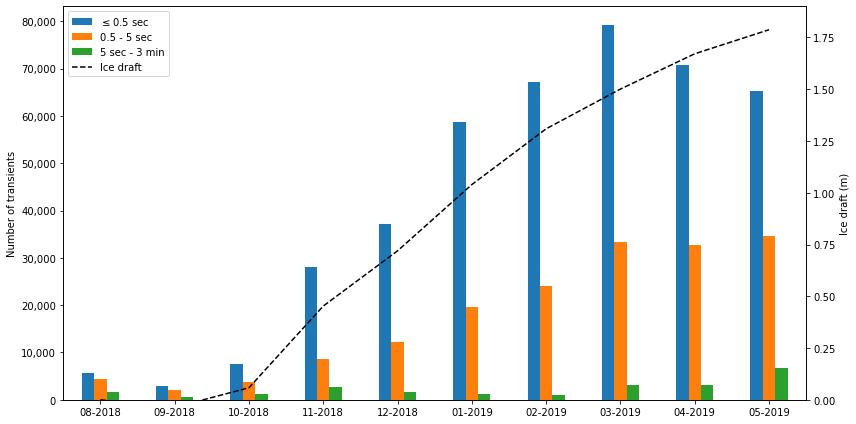

In [47]:
bar_data = pd.DataFrame({'timestamp':short_transients_df["timestamp"], 
                         'Date':short_transients_df["Date"], 
                         'short': short_transients_df["corrected_size"], 
                         'medium short': med_short_transients_df["corrected_size"], 
                         'medium': med_transients_df["corrected_size"], 
                         'retained':retained_data_df["retained"],
                         "ice_draft":ice_data["Ice Profiler"],
                         })

#bar_data.index = bar_data["timestamp"]
#bar_data = bar_data.set_index("timestamp")
bar_data.to_csv(config.interim_data_path + '/bar_data_for_formatting.csv')
bar_data

ax1 = bar_data.drop(['retained', 'ice_draft'], axis=1).plot(x='Date', kind='bar', figsize=(12,6), legend=False)
ax1.set_ylabel("Number of transients")
ax2 = bar_data['ice_draft'].plot(secondary_y=True, ls='--', label='Ice draft (m)', color="black")
ax2.set_ylabel("Ice draft (m)")

r"$0 \less \rm{d} \leq 0.5$ sec"
r"$0.5 \less \rm{d} \leq 5$ sec"
r"$5 \less \rm{d} \leq 3 \rm{min}$"
r"$3 \rm{min} \less \rm{d} \leq 20 \rm{min}$"

fig = ax1.get_figure()
fig.legend([r"$\leq 0.5$ sec", "0.5 - 5 sec", "5 sec - 3 min", "Ice draft"], loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

import matplotlib as mpl
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax2.set_ylim(0, 1.9)

ax1.set_xlabel("")

plt.tight_layout()
plt.savefig(config.figures_path + "/transient_counts_ice_draft.png", dpi=300)

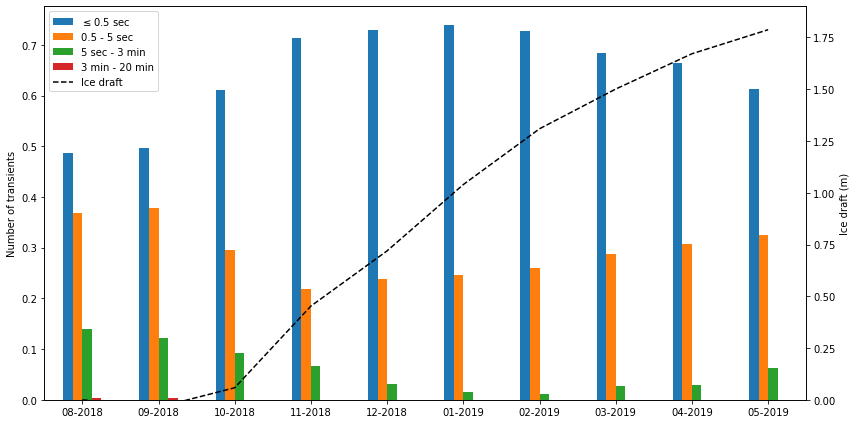

In [48]:
bar_data = pd.DataFrame({'timestamp':short_transients_df["timestamp"], 
                         'Date':short_transients_df["Date"], 
                         'short': short_transients_df["corrected_size"]/all_transients_df["corrected_size"], 
                         'medium short': med_short_transients_df["corrected_size"]/all_transients_df["corrected_size"], 
                         'medium': med_transients_df["corrected_size"]/all_transients_df["corrected_size"], 
                         'long': long_transients_df["corrected_size"]/all_transients_df["corrected_size"],
                         'retained':retained_data_df["retained"],
                         "ice_draft":ice_data["Ice Profiler"],
                         })

#bar_data.index = bar_data["timestamp"]
#bar_data = bar_data.set_index("timestamp")
bar_data.to_csv(config.interim_data_path + '/bar_data_for_formatting.csv')
bar_data

ax1 = bar_data.drop(['retained', 'ice_draft'], axis=1).plot(x='Date', kind='bar', figsize=(12,6), legend=False)
ax1.set_ylabel("Number of transients")
ax2 = bar_data['ice_draft'].plot(secondary_y=True, ls='--', label='Ice draft (m)', color="black")
ax2.set_ylabel("Ice draft (m)")
ax2.set_ylim(0, 1.9)


r"$0 \less \rm{d} \leq 0.5$ sec"
r"$0.5 \less \rm{d} \leq 5$ sec"
r"$5 \less \rm{d} \leq 3 \rm{min}$"
r"$3 \rm{min} \less \rm{d} \leq 20 \rm{min}$"

fig = ax1.get_figure()
fig.legend([r"$\leq 0.5$ sec", "0.5 - 5 sec", "5 sec - 3 min", r"3 min - 20 min", "Ice draft"], loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

ax1.set_xlabel("")

plt.tight_layout()
plt.savefig(config.figures_path + "/transient_counts_ice_draft.png", dpi=300)

# Fitting duration occurance

Trying to fit the decrease of transient occurance with increasing duration to some common function e.g. occurance ~ e^-(duration) or occurance ~ 1/(duration) but failed. Most similar to an exponential.

In [70]:
transients_by_duration = whole_year_transients_df.groupby("duration").size()
#transients_by_duration = transients_by_duration[transients_by_duration.values]
transients_by_duration

duration
0.5      279833
1.0       74248
1.5       19742
2.0        8721
2.5        4804
          ...  
331.0         1
348.5         1
389.0         1
420.0         1
452.5         1
Length: 367, dtype: int64

Text(0.5, 0, 'Duration (s)')

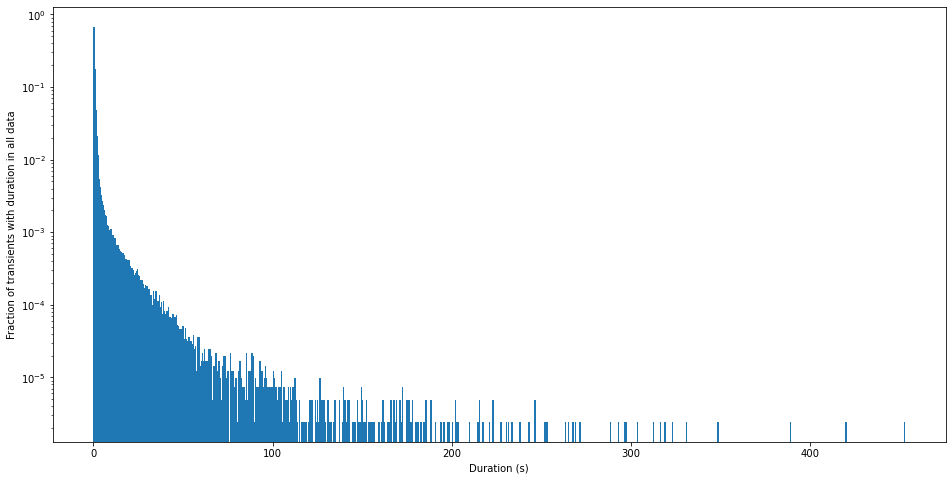

In [71]:
x_data = transients_by_duration.index
y_data = transients_by_duration.values

plt.figure(figsize=(16,8))
plt.bar(x_data, y_data/np.sum(y_data), label="data")
plt.yscale("log")
plt.ylabel("Fraction of transients with duration in all data")
plt.xlabel("Duration (s)")

In [105]:
test = transients_by_duration.cumsum()/transients_by_duration.sum()
test.values
y_data = test.values
y_data[y_data<0.99]

array([0.67869564, 0.85877374, 0.90665519, 0.92780675, 0.93945817,
       0.94695254, 0.952429  , 0.95667338, 0.95993791, 0.96265674,
       0.96499479, 0.96703209, 0.96873712, 0.97039849, 0.97182702,
       0.97310034, 0.97432999, 0.97540443, 0.97650069, 0.97759453,
       0.97846766, 0.97937474, 0.98020422, 0.98103369, 0.98169339,
       0.98237006, 0.98303704, 0.98371129, 0.98429337, 0.9848415 ,
       0.98536781, 0.98585773, 0.98637918, 0.98686183, 0.98728627,
       0.98770828, 0.98813514, 0.9885523 , 0.98893308, 0.9893454 ,
       0.98968737])

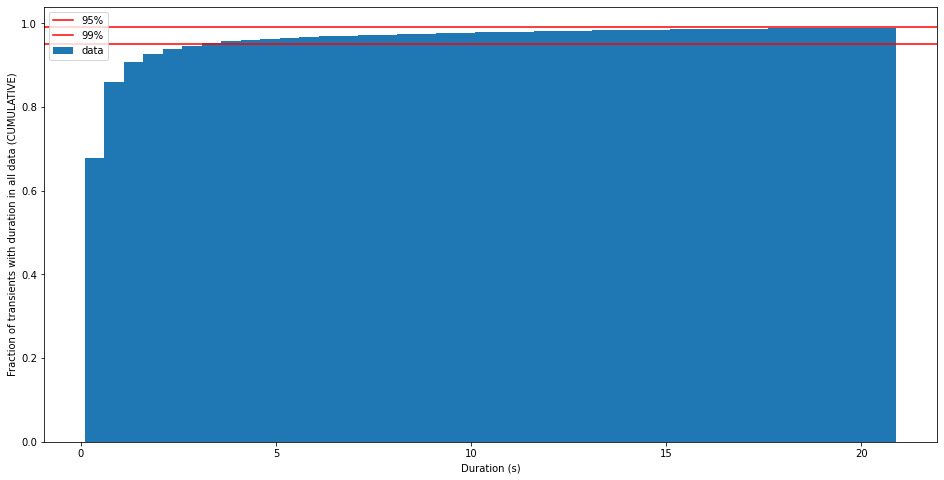

In [117]:
x_data = test.index
y_data = test.values

plt.figure(figsize=(16,8))
plt.bar(x_data[y_data < 0.99], y_data[y_data < 0.99], label="data")
#plt.yscale("log")
plt.ylabel("Fraction of transients with duration in all data (CUMULATIVE)")
plt.xlabel("Duration (s)")

plt.axhline(0.95, label="95%", color="red")
plt.axhline(0.99, label="99%", color="red")

#plt.axvline(1*60, label="1 min")
#plt.axvline(3*60, label="3 mins")

plt.legend()

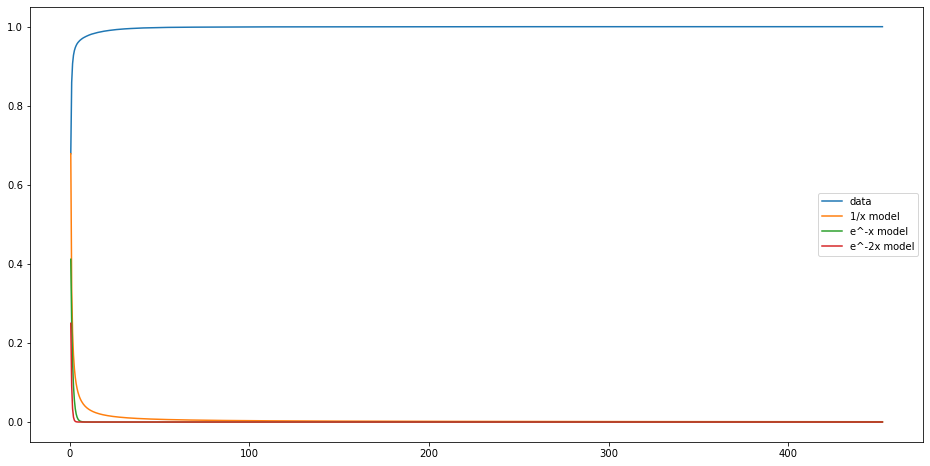

In [86]:
x_data = transients_by_duration.index
y_data = test.values

plt.figure(figsize=(16,8))
plt.plot(x_data, y_data, label="data")

plt.plot(x_data, y_data[0]*0.5/x_data, label="1/x model")
plt.plot(x_data, y_data[0]*np.exp(-x_data), label="e^-x model")
plt.plot(x_data, y_data[0]*np.exp(-2*x_data), label="e^-2x model")

'''
y_model = np.poly1d(np.polyfit(x_data, y_data, 8))
print(y_model)
plt.plot(x_data, y_model(x_data))
'''

#my_model = 2000/(-2.3 + x_data)
#plt.plot(x_data, my_model, label="my_model")

#my_model_2 = 126028/((x_data - 1.20601)*(x_data + 24.82))
#plt.plot(x_data, my_model_2, label="my_model_2")

plt.legend()

In [ ]:
x_data = transients_by_duration.index
y_data = 1/transients_by_duration.values

plt.plot(x_data, y_data, label="data")

#plt.plot(x_data, y_data[0]*0.5/x, label="e^-x model")
#plt.plot(x_data, y_data[0]*np.exp(-x_data), label="1/x model")

coeffs = np.polyfit(x_data, y_data, 2)
print(coeffs)
y_model = np.poly1d(coeffs)
plt.plot(x_data, y_model(x_data))
#plt.plot(x_data, 0.00039368*x_data)

plt.legend()

wolfram alpha:
1/(7.93475938e-06x^2 + 1.87371650e-04x -2.37513790e-04)
126028./((x - 1.20601) (x + 24.82)) (for x!=-24.82 and x!=1.20601)

#   Linearise

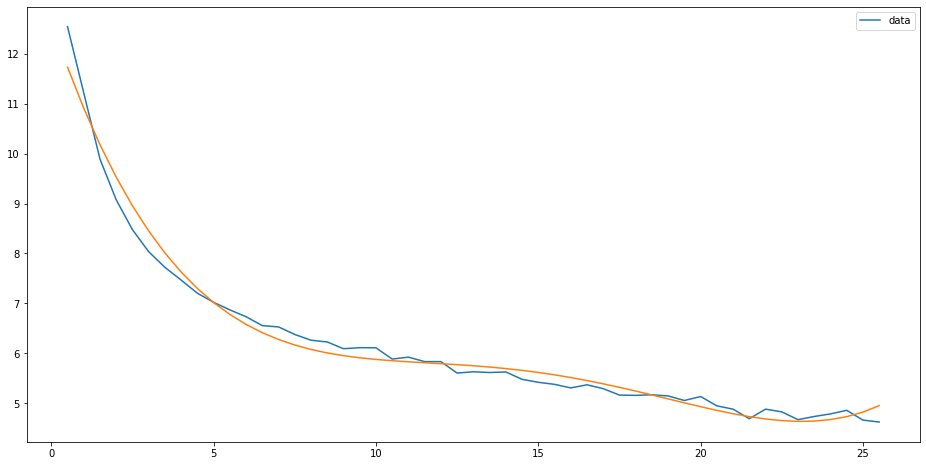

In [66]:
x_data = transients_by_duration.index
y_data = np.log(transients_by_duration.values)
plt.figure(figsize=(16,8))

plt.plot(x_data, y_data, label="data")

log_y_model = np.poly1d(np.polyfit(x_data, y_data, 4))
plt.plot(x_data, log_y_model(x_data))

plt.legend()

Apply results to non-linear.

[11.72984875 10.90984061 10.17828827  9.52869979  8.95481379  8.45059953
  8.01025684  7.62821615  7.29913852  7.01791558  6.77966957  6.57975332
  6.41375029  6.2774745   6.1669706   6.07851382  6.00861     5.95399559
  5.91163761  5.87873371  5.85271213  5.8312317   5.81218186  5.79368265
  5.77408471  5.75196926  5.72614816  5.69566384  5.65978932  5.61802826
  5.57011488  5.51601403  5.45592113  5.39026223  5.31969396  5.24510356
  5.16760885  5.08855828  5.00953089  4.9323363   4.85901475  4.79183708
  4.73330472  4.68614971  4.65333467  4.63805285  4.64372808  4.67401479
  4.73279801  4.82419338  4.95254714]


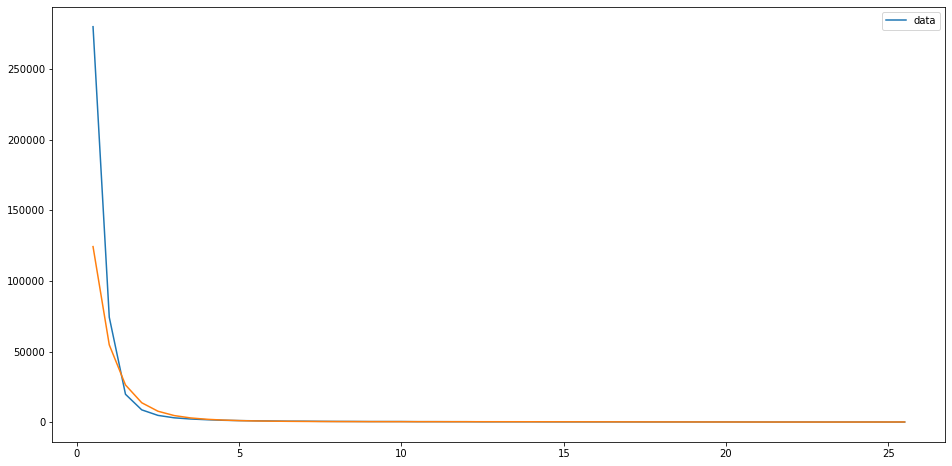

In [67]:
x_data = transients_by_duration.index
y_data = transients_by_duration.values
plt.figure(figsize=(16,8))

plt.plot(x_data, y_data, label="data")

y_model_data = np.exp(log_y_model(x_data))
plt.plot(x_data, y_model_data)

plt.legend()

In [384]:
whole_year_transients_df[(whole_year_transients_df["duration"] > 3*60) & (whole_year_transients_df["timestamp"].dt.year != 2018)].head(60)

,timestamp,broadband_spl,background_spl,duration
375201,2019-05-15 16:34:58.989,-37.393136,-50.950565,181.0
376990,2019-05-16 14:58:22.007,-22.005385,-38.375865,303.5
377037,2019-05-16 16:43:57.007,-21.406829,-31.787782,420.0
379237,2019-05-17 16:38:51.937,-32.913571,-44.378989,223.0


Result:

e^(310219. + 0.145127 x + 1.22657 x^2 + 0.99062 x^3 + 1.00015 x^4)

e^(310000. + 0.15 x + 1.2 x^2 + x^3 + x^4)